<a href="https://colab.research.google.com/github/phipi-a/temp/blob/master/device_selector_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import, load spacy model

In [ ]:
!pip install spacy==2.3.5

     |████████████████████████████████| 10.4MB 4.0MB/s 
     |████████████████████████████████| 1.1MB 26.6MB/s 
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, GlobalMaxPooling1D, Dropout, Input, MaxPooling1D, Flatten, Bidirectional, GRU, BatchNormalization ,SimpleRNN, RNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import losses
from tensorflow.keras import backend as K
import spacy
from tensorflow import keras
import tensorflow as tf
import random
import json
import sys


In [ ]:
try:
    nlp_german = spacy.load('de_core_news_lg')
except OSError:
    print('Downloading language model\n')
    from spacy.cli import download
    download('de_core_news_lg')
    nlp_german = spacy.load('de_core_news_lg')


✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_lg')


#Definitions

In [ ]:
def listToIndexLookup(actions):
    ret = {}
    for idx, action in enumerate(actions):
        ret[action] = idx
    return ret

MAX_TEXT_LENGTH = 20
VECTOR_LENGTH = 300

FORBIDDEN_POS = ["PUNCT", "SYM", "NUM", "SPACE", "DET"]
POS = [
  "ADJ",
  "ADP",
  "ADV",
  "AUX",
  "CONJ",
  "CCONJ",
  "DET",
  "INTJ",
  "NOUN",
  "NUM",
  "PART",
  "PRON",
  "PROPN",
  "SCONJ",
  "VERB",
  "X",
  "SPACE"
]
POS_LOOKUP = listToIndexLookup(POS)
POS_LENGTH = len(POS)

DEVICES = ["coffee_machine", "oven", "other"]
DEVICE_LOOKUP = listToIndexLookup(DEVICES)
DEVICES_LENGTH = len(DEVICES)

LENGTH = VECTOR_LENGTH + POS_LENGTH


In [ ]:
def getClassWeights(y):
  ret = {}
  for device in DEVICES:
    i = DEVICE_LOOKUP[device]
    ret[i] = 1 - (np.count_nonzero(y == i) / len(y))
  return ret


In [ ]:
def plot(history):
  fig, axs = plt.subplots(len(history)-len([ v for k,v in history.items() if 'val' in k]))
  z=0
  for k in range(len(history)):
      key=list(history.keys())[k]
      if not "val_" in key:
        
        axs[z].plot(history[key], label=key)
        axs[z].legend(bbox_to_anchor=(1, 1), loc='upper left',)
        if "val_"+key in history:
          axs[z].plot(history["val_"+key], label="val_"+key)
          axs[z].legend(bbox_to_anchor=(1, 1), loc='upper left',)
        z=z+1
  

In [ ]:
# your class labels
classes = DEVICES

class AccuracyCallback(tf.keras.callbacks.Callback):

    def __init__(self, test_data):
        self.test_data = test_data
        self.class_history = list()
        for i in classes:
           self.class_history.append(list())

    def on_epoch_end(self, epoch, logs=None):
        x_data, y_data = self.test_data

        correct = 0
        incorrect = 0

        x_result = self.model.predict(x_data, verbose=0)

        x_numpy = []

        class_correct = [0] * len(classes)
        class_incorrect = [0] * len(classes)

        for i in range(len(x_data)):
            x = x_data[i]
            y = y_data[i]

            res = x_result[i]

            actual_label = np.argmax(y)
            pred_label = np.argmax(res)

            if(pred_label == actual_label):
                x_numpy.append(["cor:", str(y), str(res), str(pred_label)])     
                class_correct[actual_label] += 1   
                correct += 1
            else:
                x_numpy.append(["inc:", str(y), str(res), str(pred_label)])
                class_incorrect[actual_label] += 1
                incorrect += 1

        print("\tCorrect: %d" %(correct))
        print("\tIncorrect: %d" %(incorrect))

        for i in range(len(classes)):
            tot = float(class_correct[i] + class_incorrect[i])
            class_acc = -1
            if (tot > 0):
                class_acc = float(class_correct[i]) / tot
            self.class_history[i].append(class_acc)
            print("\t%s: %.3f" %(classes[i],class_acc)) 

        acc = float(correct) / float(correct + incorrect)  

        print("\tCurrent Network Accuracy: %.3f" %(acc))

In [ ]:
def split_dataset(x,y,train_split):
  values=list(zip(x, y))
  class0=list()
  class1=list()
  class2=list()
  for index in range(len(x)):
    if np.all(y[index]==[1,0,0]):
      class0.append(values[index])
    elif np.all(y[index]==[0,1,0]):
      class1.append(values[index])
    elif np.all(y[index]==[0,0,1]):
      class2.append(values[index])
  class_weight = {
                0: int(len(class0)*train_split),
                1: int(len(class1)*train_split),
                2: int(len(class2)*train_split)}
  test=class0[:class_weight[0]]+class1[:class_weight[1]]+class2[:class_weight[2]]
  train=class0[class_weight[0]:]+class1[class_weight[1]:]+class2[class_weight[2]:]

  print("train:",len(train))
  print("test:",len(test))
  trainx=[ a for a,b in train ]
  trainy=[ b for a,b in train ]
  testx=[ a for a,b in test ]
  testy=[ b for a,b in test ]
  return trainx ,trainy, testx , testy


##data preprocessing

In [ ]:
def processSample(sample):
    doc = nlp_german(sample["text"])

    if len(doc) > MAX_TEXT_LENGTH:
        return False, None, None

    sample_x = np.empty(shape=[0, LENGTH])
    for tag in doc:
        if tag.pos_ in FORBIDDEN_POS:
            continue

        lemma_tag = nlp_german(tag.lemma_.lower())[0]

        pos = to_categorical(POS_LOOKUP[tag.pos_], POS_LENGTH)

        t = np.concatenate([lemma_tag.vector, pos])
        sample_x = np.append(sample_x, [t], axis=0)

    # fill up rest
    while len(sample_x) < MAX_TEXT_LENGTH:
        sample_x = np.append(sample_x, [np.zeros(LENGTH)], axis=0)
    device_label_keyword="label"
    device=None
    if device_label_keyword in sample.keys():
      device=DEVICE_LOOKUP[sample["label"]]
    return True, sample_x, device

#load data

In [ ]:
Xdata = np.load("drive/MyDrive/data_spacy_lg_lower/x_data.npy")
Ydata=np.load("drive/MyDrive/data_spacy_lg_lower/y_data.npy")

In [ ]:
print("Xdata.shape:",Xdata.shape)
print("Ydata.shape:",Ydata.shape)
i=1001
print("Xdata value:",Xdata[i][0])
print("Ydata value:",Ydata[i])

Xdata.shape: (49808, 20, 317)
Ydata.shape: (49808,)
Xdata value: [ 1.79799998 -0.63002998 -3.25970006 -1.11240005 -0.95103002 -0.69309002
 -2.83260012 -1.76610005 -2.43249989  4.41209984 -3.18099999 -1.67470002
  0.062507    5.03859997 -1.6221      2.65289998 -1.31599998 -2.0466001
 -0.65482002  0.99071997  0.53116    -0.74605     1.92620003 -1.26419997
  0.55897999 -2.51049995 -2.87450004 -1.17709994  1.22510004  1.95669997
  2.23900008  2.83170009 -1.54120004 -3.64989996  3.23029995 -2.33389997
 -0.3721     -0.093577    2.16280007  1.29170001 -0.92509001 -0.45644999
 -1.36479998  1.06949997  1.77740002 -0.87687999  1.57560003 -1.41180003
 -1.17060006  1.04700005  2.61730003  3.33850002  3.92470002 -1.80480003
 -3.87479997  2.41759992  1.33290005  0.24474999  6.70050001  1.12199998
  3.01209998 -2.43099999  0.91136998  1.10259998 -2.16599989 -0.60070002
  0.71731001 -3.22280002  1.63789999 -1.07439995  3.4203999   0.30465999
  3.52880001 -0.79956001  6.30770016 -3.3276      2.4052999 

#prepare training

In [ ]:
class_weight = {0: (1-(np.count_nonzero(Ydata == 0)/len(Ydata))),
                1: (1-(np.count_nonzero(Ydata == 1)/len(Ydata))),
                2: (1-(np.count_nonzero(Ydata == 2)/len(Ydata)))}
print(class_weight)

{0: 0.6176517828461292, 1: 0.6132950530035335, 2: 0.7690531641503373}


###shuffle data

In [ ]:
indices = np.arange(Xdata.shape[0])
np.random.shuffle(indices)
Xdata = Xdata[indices]
Ydata = Ydata[indices]

###to_categorical train-test split

In [ ]:
i=100
print("Ydata value: ",Ydata[i])
Y_cat=to_categorical(Ydata, 3)
print("Ydata to_categorical value: ",Y_cat[i])
trainx,trainy,testx,testy=split_dataset(Xdata,Y_cat,0.3)

Ydata value:  1.0
Ydata to_categorical value:  [0. 1. 0.]
train: 34867
test: 14941


#Define Model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 20, 40)            40680     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 123       
Total params: 50,563
Trainable params: 50,563
Non-trainable params: 0
_________________________________________________________________


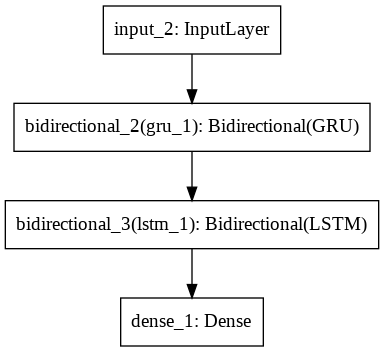

In [ ]:
model = Sequential()
model.add(Input(shape=(20, 300+17)))
model.add(Bidirectional(GRU(20,return_sequences=True,dropout=0.2)))
model.add(Bidirectional(LSTM(20,dropout=0.2)))
model.add(Dense(3,activation="softmax"))
model.build()
model.compile(
    optimizer=Adam(),
    loss=losses.categorical_crossentropy,metrics=['accuracy'])
 
model.summary()
plot_model(model)

#Training


In [ ]:
val_data=(np.asarray(testx),np.asarray(testy))
accuracy_callback = AccuracyCallback(val_data)
history=model.fit(callbacks=[accuracy_callback],x=np.asarray(trainx),y=np.asarray(trainy),batch_size=512,epochs=2,shuffle=True,class_weight=class_weight,validation_data=val_data)

Epoch 1/2
69/69 [==============================] - 19s 279ms/step - loss: 0.0303 - accuracy: 0.9847 - val_loss: 0.0381 - val_accuracy: 0.9872
	Correct: 14750
	Incorrect: 191
	coffee_machine: 0.988
	oven: 0.985
	other: 0.990
	Current Network Accuracy: 0.987
Epoch 2/2
69/69 [==============================] - 19s 271ms/step - loss: 0.0254 - accuracy: 0.9869 - val_loss: 0.0330 - val_accuracy: 0.9893
	Correct: 14781
	Incorrect: 160
	coffee_machine: 0.994
	oven: 0.984
	other: 0.992
	Current Network Accuracy: 0.989


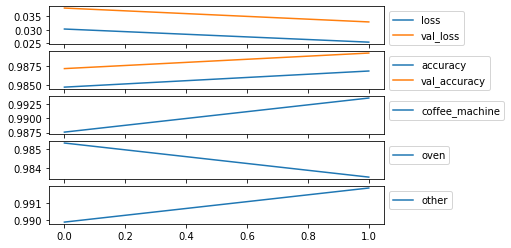

In [ ]:

z={"coffee_machine":accuracy_callback.class_history[0],"oven":accuracy_callback.class_history[1],"other":accuracy_callback.class_history[2]}
history_big = dict(history.history)
history_big.update(z)
plot(history_big)

#test model


In [ ]:
_, sequence, _ = processSample({
    "text": "kann ich bitte ein Kaffee haben"
})
prediction=model.predict(sequence.reshape((1,MAX_TEXT_LENGTH,LENGTH)))
print(prediction)
print("predicted: ", DEVICES[np.argmax(prediction)]," | ", np.round(np.max(prediction),4))

[[9.9798512e-01 1.6779958e-03 3.3695923e-04]]
predicted:  coffee_machine  |  0.998


#save model

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model_weights=model.get_weights()
np.save('model_weights.npy', model_weights)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
